In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs

import singletask_dep as st
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
encoding_type = 'absolute'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False,deps=True)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [15]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [16]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_abs_about'

In [17]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 0.9088541666666666
FEMALE 0.0875 

GLOBAL: 0.5214646464646465 

Using scikit learn accuracy por género en el conjunto to
MALE 0.9099756690997567
FEMALE 0.10236220472440945 

GLOBAL: 0.5097783572359843 

Using scikit learn accuracy por género en el conjunto as
MALE 0.8737373737373737
FEMALE 0.12129380053908356 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6876014507398372 	 Validation loss: 0.6860118952848143 	 
  1%|          | 574/57400 [00:04<07:06, 133.17it/s]
Epoch 2 	 Training loss: 0.6838307883265957 	 Validation loss: 0.6842234195288965 	 
  2%|▏         | 1148/57400 [00:09<07:00, 133.64it/s]
Epoch 3 	 Training loss: 0.682252623270613 	 Validation loss: 0.6838891011173442 	 
  3%|▎         | 1722/57400 [00:14<07:11, 129.15it/s]
Epoch 4 	 Training loss: 0.6815375135335358 	 Validation loss: 0.6835742178609816 	 
  4%|▍         | 2296/57400 [00:19<06:58, 131.77it/s]
Epoch 5 	 Training loss: 0.6813028383130396 	 Validation loss: 0.6832757309331732 	 
  5%|▌         | 2870/57400 [00:23<06:50, 132.88it/s]
Epoch 6 	 Training loss: 0.6811889292678767 	 Validation loss: 0.6834206368963597 	 
  6%|▌         | 3444/57400 [00:28<06:50, 131.53it/s]
Epoch 7 	 Training loss: 0.6810666479507805 	 Validation loss: 0.6834432917126154 	 
  7%|▋         | 4018/57400 [00:33<06:43, 132.31it/s]
Epoch 8 	 Training loss: 0.68

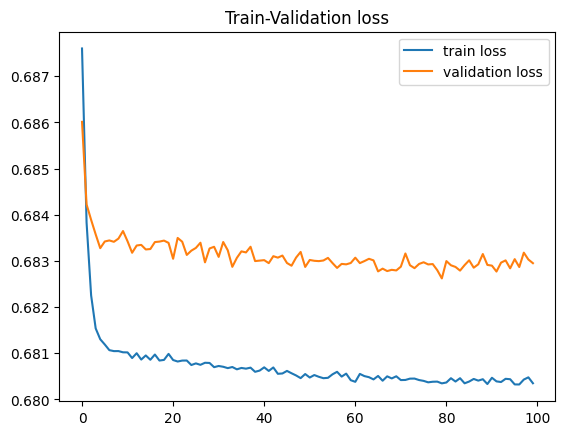

In [18]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [19]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



# TO

In [20]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [21]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_abs_to'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6947880386267805 	 Validation loss: 0.6960344203447891 	 
  1%|          | 574/57400 [00:05<08:04, 117.39it/s]
Epoch 2 	 Training loss: 0.6937348178039444 	 Validation loss: 0.6943497465828717 	 
  2%|▏         | 1148/57400 [00:10<08:03, 116.39it/s]
Epoch 3 	 Training loss: 0.6933797924983792 	 Validation loss: 0.6935918442273544 	 
  3%|▎         | 1722/57400 [00:15<07:48, 118.80it/s]
Epoch 4 	 Training loss: 0.6932766130161617 	 Validation loss: 0.6932495832443237 	 
  4%|▍         | 2296/57400 [00:21<07:51, 116.77it/s]
Epoch 5 	 Training loss: 0.693415736591359 	 Validation loss: 0.693279780573764 	 
  5%|▌         | 2870/57400 [00:26<07:48, 116.35it/s]
Epoch 6 	 Training loss: 0.6933536182712595 	 Validation loss: 0.6928832985587039 	 
  6%|▌         | 3444/57400 [00:31<07:43, 116.37it/s]
Epoch 7 	 Training loss: 0.693224656872633 	 Validation loss: 0.6930740677704246 	 
  7%|▋         | 4018/57400 [00:37<07:44, 114.98it/s]
Epoch 8 	 Training loss: 0.6934

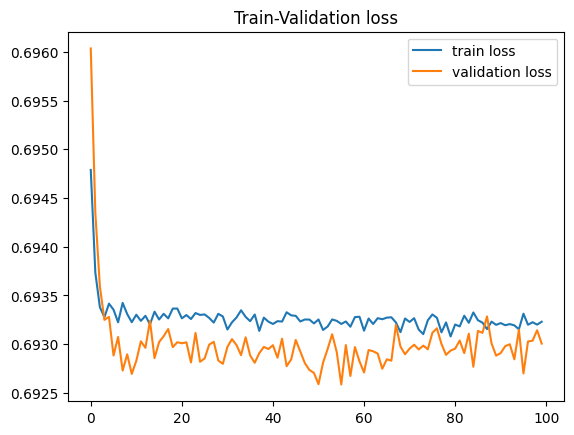

In [22]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [23]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5204081632653061 

Using scikit learn accuracy por género en el conjunto about
MALE 0.22916666666666666
FEMALE 0.8 

GLOBAL: 0.49873737373737376 

Using scikit learn accuracy por género en el conjunto to
MALE 0.26034063260340634
FEMALE 0.7559055118110236 

GLOBAL: 0.4876140808344198 

Using scikit learn accuracy por género en el conjunto as
MALE 0.22474747474747475
FEMALE 0.7681940700808625 



# AS

In [24]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_abs_as'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936221696981569 	 Validation loss: 0.692734569816266 	 
  1%|          | 574/57400 [00:05<08:00, 118.34it/s]
Epoch 2 	 Training loss: 0.6933734178127727 	 Validation loss: 0.6925004397408437 	 
  2%|▏         | 1148/57400 [00:10<07:55, 118.34it/s]
Epoch 3 	 Training loss: 0.6933780507758934 	 Validation loss: 0.6928179142838817 	 
  3%|▎         | 1722/57400 [00:15<07:49, 118.58it/s]
Epoch 4 	 Training loss: 0.6933857811037256 	 Validation loss: 0.6926992111286875 	 
  4%|▍         | 2296/57400 [00:21<07:41, 119.43it/s]
Epoch 5 	 Training loss: 0.6934948131597831 	 Validation loss: 0.6931654568445884 	 
  5%|▌         | 2870/57400 [00:26<07:52, 115.51it/s]
Epoch 6 	 Training loss: 0.6934656495624303 	 Validation loss: 0.6931442052631055 	 
  6%|▌         | 3444/57400 [00:31<07:35, 118.57it/s]
Epoch 7 	 Training loss: 0.6933827972370573 	 Validation loss: 0.693114268577705 	 
  7%|▋         | 4018/57400 [00:37<07:44, 114.93it/s]
Epoch 8 	 Training loss: 0.693

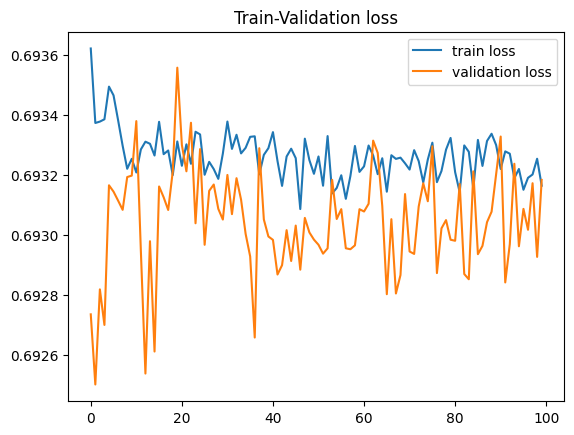

In [25]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [26]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.47831632653061223 

Using scikit learn accuracy por género en el conjunto about
MALE 0.2552083333333333
FEMALE 0.6925 

GLOBAL: 0.4911616161616162 

Using scikit learn accuracy por género en el conjunto to
MALE 0.32116788321167883
FEMALE 0.6745406824146981 

GLOBAL: 0.4876140808344198 

Using scikit learn accuracy por género en el conjunto as
MALE 0.2828282828282828
FEMALE 0.706199460916442 



# ADAM

In [27]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_abs_about_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6804097323882871 	 Validation loss: 0.6803544648623062 	 
  1%|          | 574/57400 [00:05<08:07, 116.68it/s]
Epoch 2 	 Training loss: 0.6697784459757057 	 Validation loss: 0.6649855547032114 	 
  2%|▏         | 1148/57400 [00:10<08:03, 116.28it/s]
Epoch 3 	 Training loss: 0.6561276698777069 	 Validation loss: 0.6541382316815652 	 
  3%|▎         | 1722/57400 [00:16<08:01, 115.60it/s]
Epoch 4 	 Training loss: 0.6465557314169947 	 Validation loss: 0.6465299392150621 	 
  4%|▍         | 2296/57400 [00:21<07:52, 116.58it/s]
Epoch 5 	 Training loss: 0.6391915002974068 	 Validation loss: 0.6392043616812108 	 
  5%|▌         | 2870/57400 [00:26<07:58, 114.06it/s]
Epoch 6 	 Training loss: 0.6315890176786363 	 Validation loss: 0.6313350392600238 	 
  6%|▌         | 3444/57400 [00:32<07:46, 115.75it/s]
Epoch 7 	 Training loss: 0.6252257868595655 	 Validation loss: 0.6291926078877207 	 
  7%|▋         | 4018/57400 [00:37<07:31, 118.11it/s]
Epoch 8 	 Training loss: 0.6

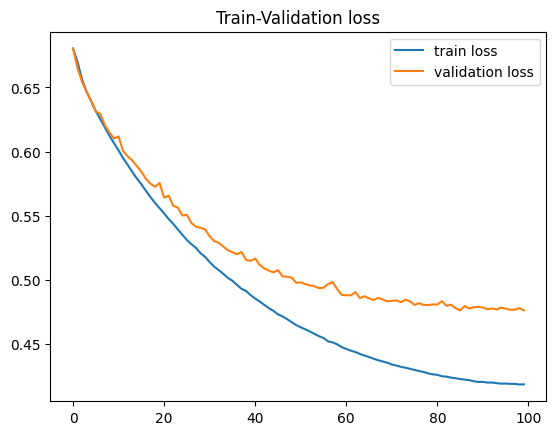

In [28]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [29]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.6964285714285714 

Using scikit learn accuracy por género en el conjunto about
MALE 0.7916666666666666
FEMALE 0.605 

GLOBAL: 0.5441919191919192 

Using scikit learn accuracy por género en el conjunto to
MALE 0.6131386861313869
FEMALE 0.46981627296587924 

GLOBAL: 0.5814863102998696 

Using scikit learn accuracy por género en el conjunto as
MALE 0.6515151515151515
FEMALE 0.5067385444743935 



# TO

In [30]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_abs_to_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693324948748645 	 Validation loss: 0.6931375709630675 	 
  1%|          | 574/57400 [00:06<09:13, 102.64it/s]
Epoch 2 	 Training loss: 0.6933693550397295 	 Validation loss: 0.6929426445799359 	 
  2%|▏         | 1148/57400 [00:12<08:58, 104.40it/s]
Epoch 3 	 Training loss: 0.6932277628561345 	 Validation loss: 0.6942761045391277 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:02, 102.67it/s]
Epoch 4 	 Training loss: 0.6931227262842531 	 Validation loss: 0.692808570498127 	 
  4%|▍         | 2296/57400 [00:23<09:01, 101.74it/s]
Epoch 5 	 Training loss: 0.6932688120765553 	 Validation loss: 0.694376719200005 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:30<08:49, 102.92it/s]
Epoch 6 	 Training loss: 0.6930459869655583 	 Validation loss: 0.6942121952267016 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:35<08:38, 104.02it/s]
Epoch 7 	 Training loss: 0.6931504521012721 	 Validation loss: 0.6933331519870435 	

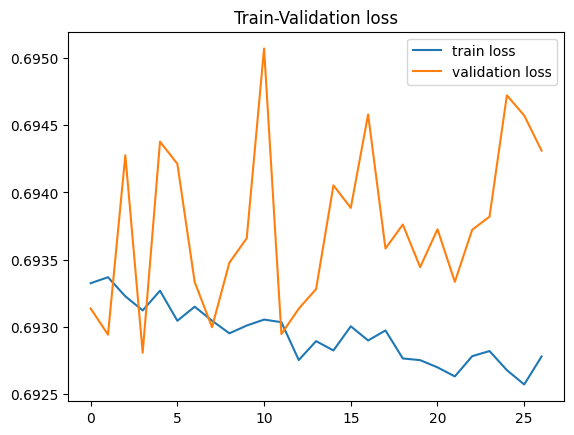

In [31]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [32]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5102040816326531 

Using scikit learn accuracy por género en el conjunto about
MALE 0.13020833333333334
FEMALE 0.875 

GLOBAL: 0.5012626262626263 

Using scikit learn accuracy por género en el conjunto to
MALE 0.170316301703163
FEMALE 0.8582677165354331 

GLOBAL: 0.47979139504563234 

Using scikit learn accuracy por género en el conjunto as
MALE 0.12121212121212122
FEMALE 0.862533692722372 



# AS

In [33]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_abs_as_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933294818168734 	 Validation loss: 0.6927585803856284 	 
  1%|          | 574/57400 [00:06<09:13, 102.68it/s]
Epoch 2 	 Training loss: 0.6933062268674166 	 Validation loss: 0.6932972497859243 	 
  2%|▏         | 1148/57400 [00:12<09:00, 104.15it/s]
Epoch 3 	 Training loss: 0.6930974949320019 	 Validation loss: 0.6922375438577038 	 
  3%|▎         | 1722/57400 [00:18<08:54, 104.24it/s]
Epoch 4 	 Training loss: 0.6931659919875008 	 Validation loss: 0.6928140712996661 	 
  4%|▍         | 2296/57400 [00:24<08:57, 102.59it/s]
Epoch 5 	 Training loss: 0.6930690158534963 	 Validation loss: 0.6931632130832995 	 
  5%|▌         | 2870/57400 [00:30<08:58, 101.36it/s]
Epoch 6 	 Training loss: 0.6930803240176278 	 Validation loss: 0.6933042204986184 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:36<08:41, 103.47it/s]
Epoch 7 	 Training loss: 0.6929494975335923 	 Validation loss: 0.6924619573657795 	 
  7%|▋         | 4018/57400 [00:42<08:29, 104.85it/s]

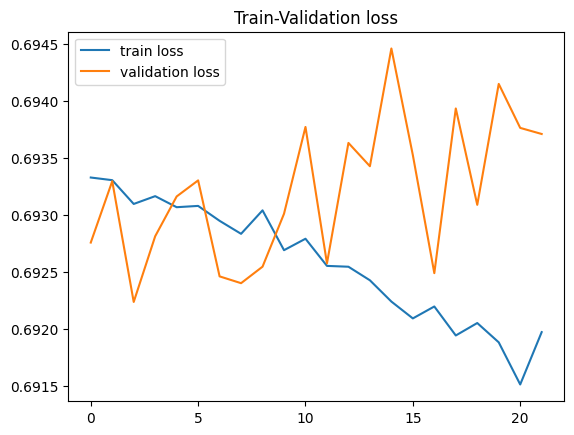

In [34]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [35]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5076530612244898 

Using scikit learn accuracy por género en el conjunto about
MALE 0.033854166666666664
FEMALE 0.9625 

GLOBAL: 0.4696969696969697 

Using scikit learn accuracy por género en el conjunto to
MALE 0.014598540145985401
FEMALE 0.9606299212598425 

GLOBAL: 0.485006518904824 

Using scikit learn accuracy por género en el conjunto as
MALE 0.022727272727272728
FEMALE 0.9784366576819407 

